<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [33]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import plotly.express as px
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_DIR = '/content/drive/MyDrive/dl_for_teachers/faces'

In [4]:
image_size = 128
batch_size = 16

In [5]:
dataset = ImageFolder(root=DATA_DIR,
                               transform=tt.Compose([
                               tt.Resize(image_size),
                               tt.CenterCrop(image_size),
                               tt.ToTensor(),
                               tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [6]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    return len(self.dl)

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
#TODO: build dataloader and transfer it to device
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

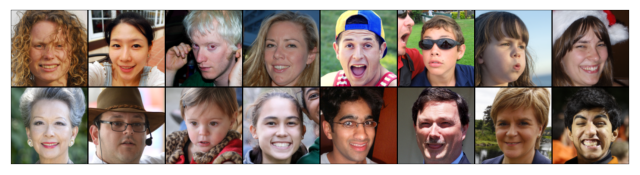

In [13]:
show_batch(data_loader)

In [14]:
data_loader = DeviceDataLoader(data_loader, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [16]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [17]:
discriminator = to_device(discriminator, device)

In [18]:
latent_size = 100

generator = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

torch.Size([16, 3, 128, 128])


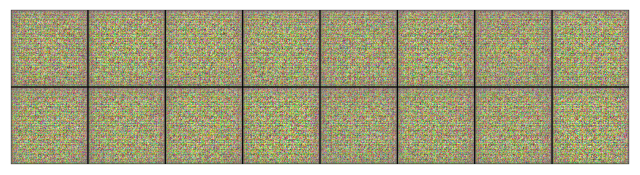

In [19]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [20]:
generator = to_device(generator, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [21]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40

In [26]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(data_loader):
            optimizer["discriminator"].zero_grad()

            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            optimizer["generator"].zero_grad()

            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [63]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 6.5316, loss_d: 0.6542, real_score: 0.8083, fake_score: 0.2068


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 6.6003, loss_d: 0.2069, real_score: 0.9343, fake_score: 0.0544


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 3.3054, loss_d: 0.8576, real_score: 0.7351, fake_score: 0.2555


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 3.3591, loss_d: 0.7812, real_score: 0.7487, fake_score: 0.2516


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 2.6867, loss_d: 0.9798, real_score: 0.6822, fake_score: 0.3178


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 2.7314, loss_d: 0.9827, real_score: 0.6776, fake_score: 0.3181


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 2.9083, loss_d: 0.9694, real_score: 0.6824, fake_score: 0.3148


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 2.6916, loss_d: 1.0051, real_score: 0.6670, fake_score: 0.3307


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 2.4983, loss_d: 1.0066, real_score: 0.6629, fake_score: 0.3321


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 2.6994, loss_d: 0.9910, real_score: 0.6662, fake_score: 0.3305


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 2.7917, loss_d: 0.9028, real_score: 0.6935, fake_score: 0.3047


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 2.7931, loss_d: 0.9297, real_score: 0.6879, fake_score: 0.3052


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 2.8284, loss_d: 0.8909, real_score: 0.7004, fake_score: 0.2980


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 3.1163, loss_d: 0.7964, real_score: 0.7266, fake_score: 0.2695


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 3.1620, loss_d: 0.7924, real_score: 0.7302, fake_score: 0.2681


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 3.2059, loss_d: 0.7583, real_score: 0.7399, fake_score: 0.2558


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 3.3463, loss_d: 0.7344, real_score: 0.7495, fake_score: 0.2470


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 3.5700, loss_d: 0.7087, real_score: 0.7635, fake_score: 0.2340


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 3.2796, loss_d: 0.6759, real_score: 0.7703, fake_score: 0.2283


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 3.5181, loss_d: 0.6615, real_score: 0.7768, fake_score: 0.2223


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 3.4945, loss_d: 0.6639, real_score: 0.7789, fake_score: 0.2205


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 3.5402, loss_d: 0.6146, real_score: 0.7902, fake_score: 0.2043


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 3.5748, loss_d: 0.6087, real_score: 0.7938, fake_score: 0.2039


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 3.5988, loss_d: 0.6273, real_score: 0.7926, fake_score: 0.2057


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 3.7661, loss_d: 0.5656, real_score: 0.8066, fake_score: 0.1919


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 3.6875, loss_d: 0.5659, real_score: 0.8111, fake_score: 0.1897


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 3.6328, loss_d: 0.5394, real_score: 0.8151, fake_score: 0.1805


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 3.7521, loss_d: 0.5591, real_score: 0.8175, fake_score: 0.1834


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 3.5570, loss_d: 0.5650, real_score: 0.8135, fake_score: 0.1828


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 3.5731, loss_d: 0.5275, real_score: 0.8228, fake_score: 0.1770


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 3.7657, loss_d: 0.4738, real_score: 0.8368, fake_score: 0.1615


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 3.8325, loss_d: 0.5454, real_score: 0.8200, fake_score: 0.1792


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 3.7425, loss_d: 0.3926, real_score: 0.8550, fake_score: 0.1418


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 3.9660, loss_d: 0.4904, real_score: 0.8403, fake_score: 0.1608


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 3.7824, loss_d: 0.4921, real_score: 0.8360, fake_score: 0.1621


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 3.8346, loss_d: 0.3806, real_score: 0.8623, fake_score: 0.1351


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 4.0134, loss_d: 0.4993, real_score: 0.8408, fake_score: 0.1591


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 5.0753, loss_d: 0.4071, real_score: 0.8689, fake_score: 0.1327


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 4.0993, loss_d: 0.3845, real_score: 0.8650, fake_score: 0.1322


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 3.9567, loss_d: 0.4641, real_score: 0.8522, fake_score: 0.1460
Saving generated-images-0040.png


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [64]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [65]:
losses_g, losses_d, real_scores, fake_scores = history

In [66]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

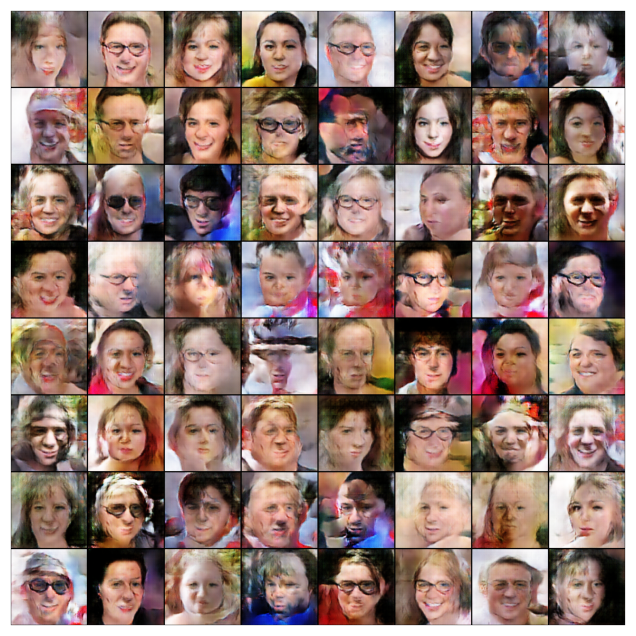

In [67]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [27]:
generator.eval()
fake_images = generator(torch.randn(1000, 100, 1, 1, device=device))
fake_images = fake_images.reshape(fake_images.shape[0], -1)

real_images = [i[0] for i in tqdm(dataset)][:1000]
real_images = torch.stack(real_images).reshape(fake_images.shape[0], -1)

  0%|          | 0/3143 [00:00<?, ?it/s]

In [28]:
X = torch.concat([real_images.cpu(), fake_images.cpu()]).detach().numpy()
y = torch.concat((torch.ones(1000), torch.zeros(1000))).numpy()

In [31]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=1), X, y, cv=LeaveOneOut())

In [32]:
scores.mean()

0.976

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [34]:
tsne = TSNE(n_components=2).fit_transform(X)

Прокомментируйте получившийся результат:

In [36]:
fig = px.scatter(tsne, x=0, y=1, color=y.astype(str),labels={'0': 'tsne1', '1': 'tsne2'})
fig.show()